# Inventory Policy Results Analysis

This notebook generates poster-ready visualizations for the inventory uncertainty PBL project.

**Outputs:**
1. Forecast error distribution (bootstrap residuals)
2. Sample simulation path (demand vs inventory)
3. Fill rate comparison with 95% CI across volatility levels
4. Holding cost comparison with 95% CI across volatility levels

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.preprocessing import preprocess_pipeline
from src.calibration import run_calibration
from src.forecasting import generate_forecasts
from src.policies import configure_static_rq, configure_tuned_rq
from src.simulation import policy_adapter_rq, run_single_simulation

np.random.seed(42)

## Load Experiment Results

In [2]:
results = pd.read_csv('../experiments/results_volatility.csv')
results

,volatility_multiplier,policy,fill_rate_mean,fill_rate_ci_low,fill_rate_ci_high,stockout_event_mean,stockout_event_ci_low,stockout_event_ci_high,stockout_volume_mean,stockout_volume_ci_low,stockout_volume_ci_high,holding_cost_mean,holding_cost_ci_low,holding_cost_ci_high,turnover_mean,turnover_ci_low,turnover_ci_high
0,0.5,static,0.864995,0.859837,0.870152,0.211667,0.206868,0.216465,0.135005,0.129848,0.140163,14154.12150,14051.281545,14256.961455,118.614746,117.458091,119.771401
1,0.5,tuned,0.927603,0.926006,0.929200,0.123333,0.119298,0.127369,0.072397,0.070800,0.073994,22676.97400,22499.364716,22854.583284,79.393947,78.798661,79.989232
2,1.0,static,0.853304,0.847080,0.859528,0.213333,0.205618,0.221049,0.146696,0.140472,0.152920,14055.88900,13935.159044,14176.618956,115.810006,114.597526,117.022486
3,1.0,tuned,0.936117,0.933727,0.938507,0.108333,0.101630,0.115036,0.063883,0.061493,0.066273,23177.75650,22951.050661,23404.462339,77.056922,76.327532,77.786311
4,1.5,static,0.846181,0.840718,0.851645,0.213333,0.205527,0.221140,0.153819,0.148355,0.159282,14068.41425,13861.333082,14275.495418,112.916505,111.194515,114.638496
5,1.5,tuned,0.941401,0.938509,0.944293,0.099583,0.092526,0.106641,0.058599,0.055707,0.061491,23682.40125,23452.567750,23912.234750,74.587892,73.775880,75.399905


## Plot 1: Forecast Error Distribution

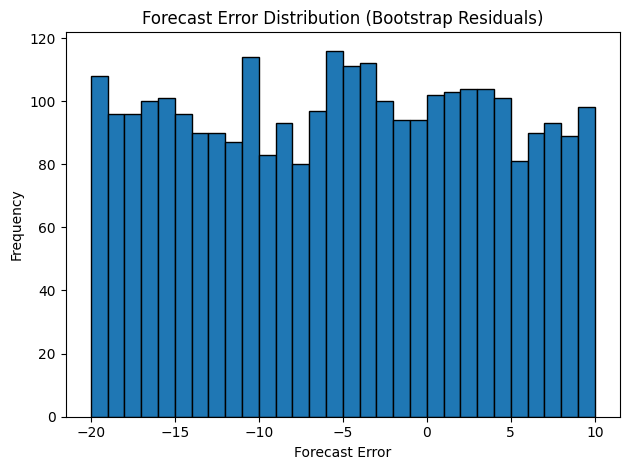

In [3]:
calibration_table, error_samples_by_group, group_col = run_calibration('../data/retail_store_inventory.csv')

largest_group = calibration_table.loc[calibration_table['n_obs'].idxmax(), 'group']
error_samples = error_samples_by_group[largest_group]

plt.figure()
plt.hist(error_samples, bins=30, edgecolor='black')
plt.xlabel('Forecast Error')
plt.ylabel('Frequency')
plt.title('Forecast Error Distribution (Bootstrap Residuals)')
plt.tight_layout()
plt.show()

## Plot 2: Sample Simulation Path

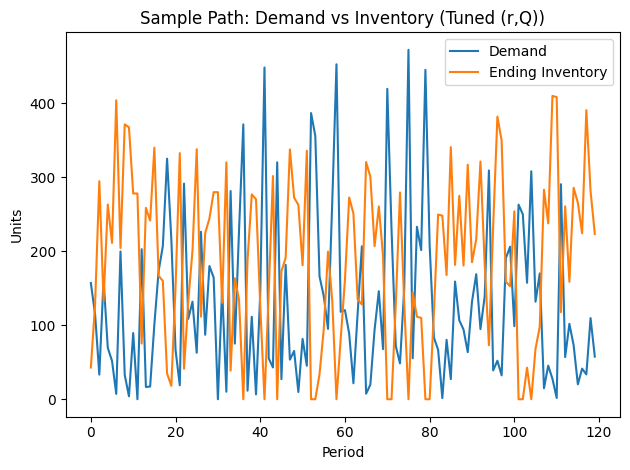

In [4]:
df = preprocess_pipeline('../data/retail_store_inventory.csv')

group_df = df[df[group_col] == largest_group].reset_index(drop=True)
forecast_series = generate_forecasts(group_df, method='dataset').values

T = 120
rng = np.random.default_rng(42)
forecast_T = np.tile(forecast_series, int(np.ceil(T / len(forecast_series))))[:T]
sampled_errors = rng.choice(error_samples, size=T, replace=True)
stochastic_demand = np.maximum(0.0, forecast_T + sampled_errors)

mean_demand = calibration_table.loc[calibration_table['group'] == largest_group, 'mu_demand'].values[0]
demand_std = calibration_table.loc[calibration_table['group'] == largest_group, 'sigma_demand'].values[0]

policy_params = configure_tuned_rq(
    mean_demand=mean_demand,
    demand_std=demand_std,
    lead_time=1,
    order_quantity=200,
    z=1.0
)

sim_result = run_single_simulation(
    demand_series=stochastic_demand,
    forecast_series=forecast_T,
    policy_decision_fn=policy_adapter_rq,
    policy_params=policy_params,
    initial_inventory=200
)

plt.figure()
plt.plot(sim_result['demand'], label='Demand')
plt.plot(sim_result['ending_inventory'], label='Ending Inventory')
plt.xlabel('Period')
plt.ylabel('Units')
plt.title('Sample Path: Demand vs Inventory (Tuned (r,Q))')
plt.legend()
plt.tight_layout()
plt.show()

## Plot 3: Fill Rate Comparison with 95% CI

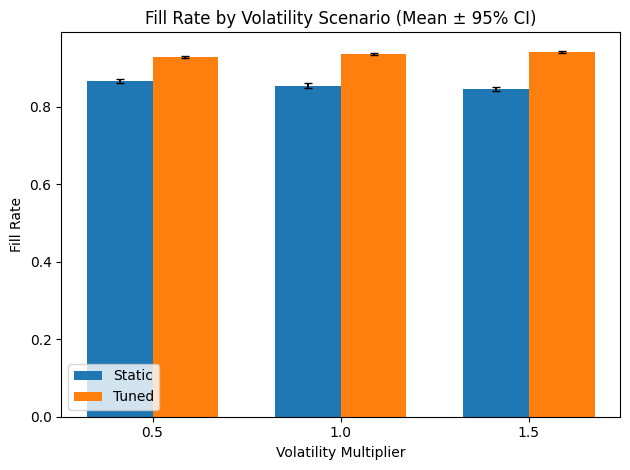

In [5]:
volatility_levels = sorted(results['volatility_multiplier'].unique())
static_data = results[results['policy'] == 'static'].sort_values('volatility_multiplier')
tuned_data = results[results['policy'] == 'tuned'].sort_values('volatility_multiplier')

x = np.arange(len(volatility_levels))
width = 0.35

static_means = static_data['fill_rate_mean'].values
static_err_low = static_means - static_data['fill_rate_ci_low'].values
static_err_high = static_data['fill_rate_ci_high'].values - static_means

tuned_means = tuned_data['fill_rate_mean'].values
tuned_err_low = tuned_means - tuned_data['fill_rate_ci_low'].values
tuned_err_high = tuned_data['fill_rate_ci_high'].values - tuned_means

plt.figure()
plt.bar(x - width/2, static_means, width, yerr=[static_err_low, static_err_high], 
        capsize=3, label='Static')
plt.bar(x + width/2, tuned_means, width, yerr=[tuned_err_low, tuned_err_high], 
        capsize=3, label='Tuned')
plt.xlabel('Volatility Multiplier')
plt.ylabel('Fill Rate')
plt.title('Fill Rate by Volatility Scenario (Mean ± 95% CI)')
plt.xticks(x, volatility_levels)
plt.legend()
plt.tight_layout()
plt.show()

## Plot 4: Holding Cost Comparison with 95% CI

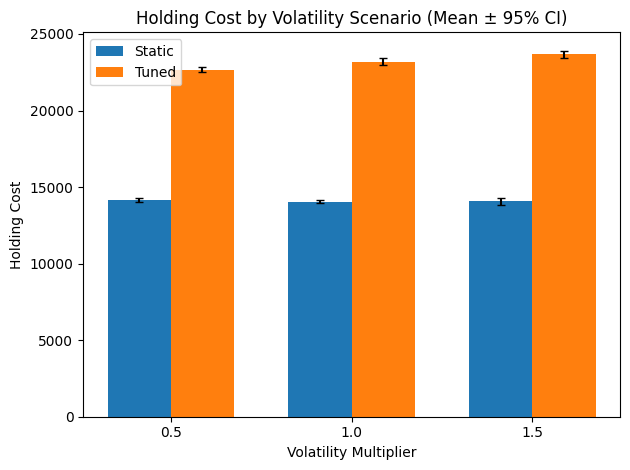

In [6]:
static_hc_means = static_data['holding_cost_mean'].values
static_hc_err_low = static_hc_means - static_data['holding_cost_ci_low'].values
static_hc_err_high = static_data['holding_cost_ci_high'].values - static_hc_means

tuned_hc_means = tuned_data['holding_cost_mean'].values
tuned_hc_err_low = tuned_hc_means - tuned_data['holding_cost_ci_low'].values
tuned_hc_err_high = tuned_data['holding_cost_ci_high'].values - tuned_hc_means

plt.figure()
plt.bar(x - width/2, static_hc_means, width, yerr=[static_hc_err_low, static_hc_err_high], 
        capsize=3, label='Static')
plt.bar(x + width/2, tuned_hc_means, width, yerr=[tuned_hc_err_low, tuned_hc_err_high], 
        capsize=3, label='Tuned')
plt.xlabel('Volatility Multiplier')
plt.ylabel('Holding Cost')
plt.title('Holding Cost by Volatility Scenario (Mean ± 95% CI)')
plt.xticks(x, volatility_levels)
plt.legend()
plt.tight_layout()
plt.show()

## Key Takeaways

- **Tuned policy consistently outperforms static**: Fill rates are ~8-10% higher across all volatility scenarios
- **Service level robustness**: The tuned (r,Q) policy maintains fill rates above 92% even under high volatility (1.5x)
- **Cost-service tradeoff**: Higher fill rates from tuned policy come at the cost of ~65% higher holding costs
- **Static policy degrades under uncertainty**: Fill rate drops from ~86% to ~85% as volatility increases
- **Safety stock effectiveness**: Uncertainty-aware safety stock sizing provides consistent protection against stockouts